In [1]:
# General scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import pandas as pd
import time
from string import ascii_lowercase
from scipy import special
from scipy import integrate
from scipy.special import roots_legendre, eval_legendre
from scipy.constants import mu_0, epsilon_0
# Machine Epssilon for float
import ipywidgets
import time
from PIL import Image
import os
eps = np.finfo(float).eps

In [2]:
# Specific Geophysics libraries
import empymod
# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import time_domain as tdem
from simpeg.electromagnetics import resistivity as dc
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from geoana.em.tdem import diffusion_distance
from geoana.em.tdem import peak_time
from pymatsolver import Pardiso

In [3]:
from masa_utils import PsuedoLog
from masa_utils import TEM_Signal_Process
from masa_utils import empymod_IPinv


## Define Transmitter, Mesh Plot

WISTEM uses a 3.5m rectangular loop for the JOGMEC survey.  
Convert it into a 2.0m circular loop in cylindrical coordinates.  

K. Nakayama, M. Moroori, A. Saito, 2019, *Application of Time-Domain Electromagnetic Survey for Seafloor Polymetallic Sulphides in the Okinawa Trough*, EAGE, 25th European Meeting of Environmental and Engineering Geophysics.


In [4]:
base_freq=1.25
on_time=0.2
rmp_time=260e-6
rec_time=0.2
smp_freq=50e3
time_step=1./smp_freq

In [5]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumference = 2*np.pi*tx_radius
tx_area = np.pi*tx_radius**2
tx_depth = 0
n_turns = 5

In [6]:
csx, csz = tx_radius/4.,tx_radius/4.
ncx, ncz  = 100, 100 
# ncx, ncz  = 200, 200 
pf, npadx, npadz = 1.3 , 26, 26
mesh = discretize.CylindricalMesh(
    [[(csx, ncx), (csx, npadx, pf)], [np.pi*2], [(csz, npadz, -pf), (csz, 2*ncz), (csz, npadz, pf)]], 
    origin = "000"
)
mesh.origin = np.r_[0, 0, -mesh.h[2][:npadz+ncz].sum()]
print(f"Cell size: {csx}, number of cells in center: {ncx}")
tx_height = csx
print(mesh.n_cells)

Cell size: 0.4936658856042868, number of cells in center: 100
31752


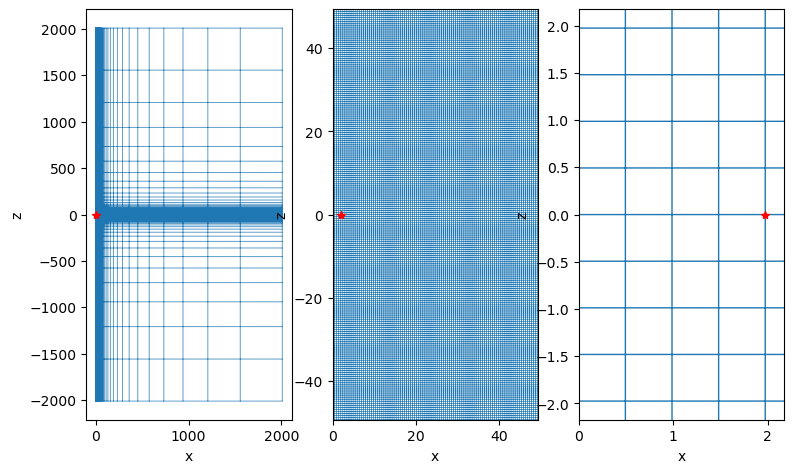

In [7]:
fig, ax = plt.subplots(1,3, figsize=(9,7))
ax[0] = mesh.plot_grid(ax=ax[0], show_it=False, linewidth=0.5)  
ax[1] =  mesh.plot_grid(ax=ax[1], show_it=False, linewidth=0.5)
#ax[1] =  mesh.plot_grid(show_it=True)
ax[1].set_xlim(0., ncx*csx)
ax[1].set_ylim(-ncz*csz , ncz*csz )
ax[2] =  mesh.plot_grid(ax=ax[2], show_it=False, linewidth=1.0)
ax[2].set_xlim(0.,tx_radius*1.1)
ax[2].set_ylim(-tx_radius*1.1,tx_radius*1.1)

for a in ax:
    a.set_aspect('equal')
    a.plot(tx_radius,0,'r*')
    a.grid(False)

## Define Mesh and time steps
ramp time 200 $ \mu $ sec    
K. Nakayama, 2016, Practical marine TDEM systems using ROV for the ocean bottom hydrothermal deposits, Techno-Ocean Kobe, Japan, 2016

In [8]:
sigma_air = 1e-8
sigma_sea = 3.3
thick_sea = 1000.1
sigma_seabed = 1.0
sigma_target = 5.0
radius_target = 30.
thick_target = 30.
#tx_height = 0.5
tx_current = 1

In [9]:
sigma_ref = {}
m = sigma_air * np.ones(mesh.n_cells)
m[mesh.cell_centers[:, 2] < thick_sea] = sigma_sea
sigma_ref = m.copy()

In [10]:
time_steps = [(2e-6,  150),  (5e-6,  150),  (2e-5,  150), (5e-5,  150)]
tstrt, tend = 1e-5, 1e-2

steps = np.array([])
for i in range(len(time_steps)):
    dt, n = time_steps[i]
    step_array = dt * np.ones(n)
    steps = np.concatenate((steps, step_array))
time_clc = np.cumsum(steps)
rmp_time =  time_clc[0] # 200e-6 
print(rmp_time)
time_clc = time_clc[time_clc < tend+eps ]
time_rec = np.logspace(np.log10(tstrt), np.log10(tend), 31)

2e-06


In [11]:
waveform=tdem.sources.StepOffWaveform()
#waveform=tdem.sources.RampOffWaveform(off_time=rmp_time)

# EMF is calculated as integration of dB/dt over the are of the loop 
rx_z = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, 0, 0], times=time_clc, orientation="z"
)
# EMF is calculated as integration of E-field over the loop wire 
rx_x = tdem.receivers.PointElectricField(
    locations=np.r_[tx_radius, 0, 0 ], times=time_clc, orientation="y"
)
src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, 0], radius=tx_radius, receiver_list=[rx_x, rx_z],
    waveform=waveform, n_turns=n_turns,
)
survey = tdem.Survey([src])
sim = tdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey,  solver=Pardiso, time_steps=time_steps,
    sigmaMap=maps.IdentityMap(mesh)
)


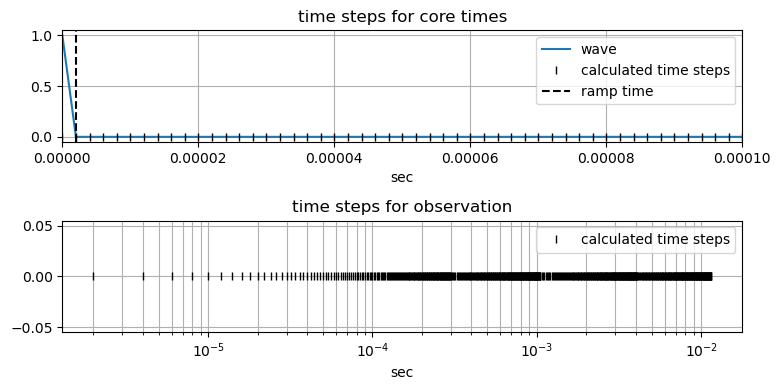

In [12]:
fig, ax = plt.subplots(2,1,figsize=(8,4))
ax[0].plot(sim.times, [waveform.eval(t) for t in sim.times],label='wave')
ax[0].plot(sim.times, np.zeros_like(sim.times), "|k",label='calculated time steps')
#ax[0].plot(time_rec+rmp_time, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[0].axvline(rmp_time, color='k', linestyle='--',label='ramp time')
ax[0].set_xlim(0,1e-4)#time_steps[0][0]*time_steps[0][1])
ax[0].set_title('time steps for core times')

ax[1].semilogx(sim.times, np.zeros_like(sim.times), "|k",label='calculated time steps')
#ax[1].semilogx(time_rec+rmp_time, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[1].set_title('time steps for observation')

for a in ax:
    a.grid(which='both')
    a.set_xlabel('sec')
    a.legend()
plt.tight_layout()
plt.show()

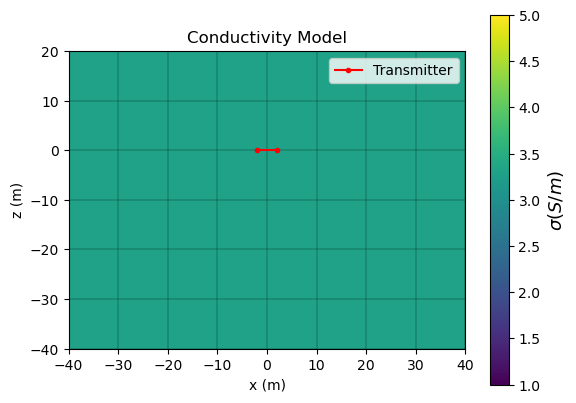

In [13]:
fig, ax = plt.subplots(1,1)
cb = plt.colorbar(mesh.plot_image((sigma_ref),clim=[1,5],ax=ax, mirror=True)[0])
    # plot the source locations and earth surface
ax.plot(np.r_[src.radius,-src.radius],np.r_[src.location[2],src.location[2]],"ro-", markersize=3,label="Transmitter")

# plot formatting and titles
#cb.set_label('$\log_{10}\sigma$', fontsize=13)
cb.set_label('$\sigma (S/m)$', fontsize=13)
#ax.axis('equal')
ax.set_xlim([-40., 40.])
ax.set_ylim([-40., 20.])
ax.set_aspect('equal')
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.legend()
ax.grid(which='both', color='k', linestyle='-', linewidth=0.2)
ax.set_title('Conductivity Model');

## SimpegSimulation

In [14]:
fields_ref = sim.fields(sigma_ref)


In [15]:
dpred_ref = sim.dpred(sigma_ref, f=fields_ref)


In [16]:
dpred_ref_ebple = dpred_ref[:len(rx_x.times)]
dpred_ref_bdple = dpred_ref[len(rx_x.times):]
dpred_simpeg_ebple = dpred_ref_ebple[time_clc > rmp_time] * tx_circumference
dpred_simpeg_bdple = -dpred_ref_bdple[time_clc > rmp_time] * tx_area
time_simpeg = time_clc[time_clc > rmp_time]-rmp_time

# Empymod simulation

In [30]:
time_empymod = time_clc
nlayer = 2
tx_height = 0.3
depth = tx_height+np.r_[0,20]
res = np.r_[1/sigma_sea,1/sigma_sea,1/sigma_sea]
print(f'number of time channels: {len(time_empymod)}')
#tr_side = 3.5

number of time channels: 569


In [31]:
time_empymod, freq, ft, ftarg = empymod.utils.check_time(
    time=time_clc,          # Required times
    signal=1,           # Switch-on response
    ft= 'fftlog',
    ftarg= {'add_dec': [-5, 5], 'pts_per_dec': 20},
#    ft='dlf',           # Use DLF
#    ftarg={'dlf': 'key_81_2009'},  # Short, fast filter; if you
    verb=2,                 # need higher accuracy choose a longer filter.
)
#print(time_empymod)
#print(len(freq))
#orint(freq)
#print(ft)
print(ftarg)


{'pts_per_dec': array(20), 'add_dec': array([-5.,  5.]), 'q': array(0.), 'mu': 0.5, 'tcalc': array([2.08170795e-11, 2.35021800e-11, 2.65336193e-11, 2.99560702e-11,
       3.38199675e-11, 3.81822514e-11, 4.31072064e-11, 4.86674089e-11,
       5.49447967e-11, 6.20318762e-11, 7.00330859e-11, 7.90663352e-11,
       8.92647423e-11, 1.00778596e-10, 1.13777568e-10, 1.28453220e-10,
       1.45021816e-10, 1.63727521e-10, 1.84845990e-10, 2.08688433e-10,
       2.35606205e-10, 2.65995979e-10, 3.00305591e-10, 3.39040643e-10,
       3.82771954e-10, 4.32143968e-10, 4.87884254e-10, 5.50814226e-10,
       6.21861248e-10, 7.02072303e-10, 7.92629417e-10, 8.94867082e-10,
       1.01029192e-09, 1.14060488e-09, 1.28772632e-09, 1.45382428e-09,
       1.64134646e-09, 1.85305628e-09, 2.09207358e-09, 2.36192064e-09,
       2.66657405e-09, 3.01052331e-09, 3.39883703e-09, 3.83723756e-09,
       4.33218539e-09, 4.89097428e-09, 5.52183882e-09, 6.23407570e-09,
       7.03818078e-09, 7.94600372e-09, 8.97092261e-09, 

In [32]:
# emoymod model to simulate WISTEM setting 
empymod_model_ebple = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ [ tx_side/2,  tx_side/2, -tx_side/2, -tx_side/2],  # x1
             [ tx_side/2, -tx_side/2, -tx_side/2,  tx_side/2],  # x2
             [-tx_side/2,  tx_side/2,  tx_side/2, -tx_side/2],  # y1
             [ tx_side/2,  tx_side/2, -tx_side/2, -tx_side/2],  # y2
                tx_depth,  tx_depth], # z1, z2
   # receiver is bipole about half of the side of transmitter loop
#    'res' : res, 
    'rec': [ tx_side/2 , tx_side/2,  # x1,x2
                    0, tx_side/2,  # y1,y2
             tx_depth, tx_depth], # z1,z2
    'depth': depth,
    'freqtime': time_empymod,
    'signal': -1, # Step off response
    'msrc' : False, # Electric source
    'mrec' : False, # Electric receiver
    'strength': 8* n_turns , # Multiply 8 cosidering the size of receiver bipole  
    'srcpts' : 3, # Three works for the momtent, maybe worth seeking larger number
    'verb': 4, # put 4 if you require information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [33]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_bdple = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ [ tx_side/2,  tx_side/2, -tx_side/2, -tx_side/2],  # x1
             [ tx_side/2, -tx_side/2, -tx_side/2,  tx_side/2],  # x2
             [-tx_side/2,  tx_side/2,  tx_side/2, -tx_side/2],  # y1
             [ tx_side/2,  tx_side/2, -tx_side/2, -tx_side/2],  # y2
                tx_depth,  tx_depth], 
    # receiver at the center of the transmitter loop
#    'res' : res, 
    'rec': [ 0,0,tx_depth,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
    'freqtime': time_empymod,
    'signal': 0, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': n_turns * tx_area * mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 4, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,

}

In [34]:
# emoymod model to simulate WISTEM setting 
empymod_model_ebple_f = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ [ tx_side/2,  tx_side/2, -tx_side/2, -tx_side/2],  # x1
             [ tx_side/2, -tx_side/2, -tx_side/2,  tx_side/2],  # x2
             [-tx_side/2,  tx_side/2,  tx_side/2, -tx_side/2],  # y1
             [ tx_side/2,  tx_side/2, -tx_side/2, -tx_side/2],  # y2
                tx_depth,  tx_depth], # z1, z2
   # receiver is bipole about half of the side of transmitter loop
#    'res' : res, 
    'rec': [ tx_side/2 , tx_side/2,  # x1,x2
                    0, tx_side/2,  # y1,y2
             tx_depth, tx_depth], # z1,z2
    'depth': depth,
    'freqtime': freq,
#    'signal': None, # Step off response
    'msrc' : False, # Electric source
    'mrec' : False, # Electric receiver
    'strength': 8* n_turns , # Multiply 8 cosidering the size of receiver bipole  
    'srcpts' : 3, # Three works for the momtent, maybe worth seeking larger number
    'verb': 4, # put 4 if you require information
#    'htarg':{'dlf': 'key_201_2012'},  #
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [35]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_bdple_f = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ [ tx_side/2,  tx_side/2, -tx_side/2, -tx_side/2],  # x1
             [ tx_side/2, -tx_side/2, -tx_side/2,  tx_side/2],  # x2
             [-tx_side/2,  tx_side/2,  tx_side/2, -tx_side/2],  # y1
             [ tx_side/2,  tx_side/2, -tx_side/2, -tx_side/2],  # y2
                tx_depth,  tx_depth], 
    # receiver at the center of the transmitter loop
#    'res' : res, 
    'rec': [ 0,0,tx_depth,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
    'freqtime': freq,
 #   'signal': 0, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': n_turns * tx_area * mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 4, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,

}

In [36]:
empymod_bdple_f_four = empymod.bipole(res=res, **empymod_model_bdple_f)
## Sum the four sides of the transmitter loop
empymod_bdple_f = np.sum(empymod_bdple_f_four, axis=1)
# Multiply by the number of turns
empymod_dpred_bdple_f =  -empymod_bdple_f* 2j *np.pi*freq

print(f'empymod_bple: {empymod_dpred_bdple_f}')



:: empymod START  ::  v2.3.2

   depth       [m] :  0.3 20.3
   res     [Ohm.m] :  0.30303 0.30303 0.30303
   aniso       [-] :  1 1 1
   epermH      [-] :  1 1 1
   epermV      [-] :  1 1 1
   mpermH      [-] :  1 1 1
   mpermV      [-] :  1 1 1

>  MODEL IS A FULLSPACE; returning analytical frequency-domain solution
   direct field    :  Comp. in frequency domain
   frequency  [Hz] :  0.000169108 - 7.48938E+09 : 260  [min-max; #]
                   :  0.000169108 0.000190921 0.000215547 0.000243349 0.000274737 0.000310174 0.000350182 0.000395351 0.000446345 0.000503917 0.000568916 0.000642297 0.000725144 0.000818677 0.000924275 0.00104349 0.00117809 0.00133004 0.0015016 0.00169529 0.00191395 0.00216082 0.00243954 0.00275421 0.00310946 0.00351053 0.00396334 0.00447455 0.00505171 0.0057033 0.00643894 0.00726947 0.00820713 0.00926573 0.0104609 0.0118102 0.0133335 0.0150533 0.016995 0.0191871 0.021662 0.0244561 0.0276105 0.0311719 0.0351926 0.039732 0.0448568 0.0506427 0.0571748 0.06454

In [37]:
empymod_ebple_f_four = empymod.bipole(res=res, **empymod_model_ebple_f)
## Sum the four sides of the transmitter loop
empymod_ebple_f = np.sum(empymod_ebple_f_four, axis=1)
# Multiply by the number of turns
empymod_dpred_ebple_f =  empymod_ebple_f # * 2j *np.pi*freq

print(f'empymod_bple: {empymod_dpred_ebple_f}')



:: empymod START  ::  v2.3.2

   depth       [m] :  0.3 20.3
   res     [Ohm.m] :  0.30303 0.30303 0.30303
   aniso       [-] :  1 1 1
   epermH      [-] :  1 1 1
   epermV      [-] :  1 1 1
   mpermH      [-] :  1 1 1
   mpermV      [-] :  1 1 1

>  MODEL IS A FULLSPACE; returning analytical frequency-domain solution
   direct field    :  Comp. in frequency domain
   frequency  [Hz] :  0.000169108 - 7.48938E+09 : 260  [min-max; #]
                   :  0.000169108 0.000190921 0.000215547 0.000243349 0.000274737 0.000310174 0.000350182 0.000395351 0.000446345 0.000503917 0.000568916 0.000642297 0.000725144 0.000818677 0.000924275 0.00104349 0.00117809 0.00133004 0.0015016 0.00169529 0.00191395 0.00216082 0.00243954 0.00275421 0.00310946 0.00351053 0.00396334 0.00447455 0.00505171 0.0057033 0.00643894 0.00726947 0.00820713 0.00926573 0.0104609 0.0118102 0.0133335 0.0150533 0.016995 0.0191871 0.021662 0.0244561 0.0276105 0.0311719 0.0351926 0.039732 0.0448568 0.0506427 0.0571748 0.06454

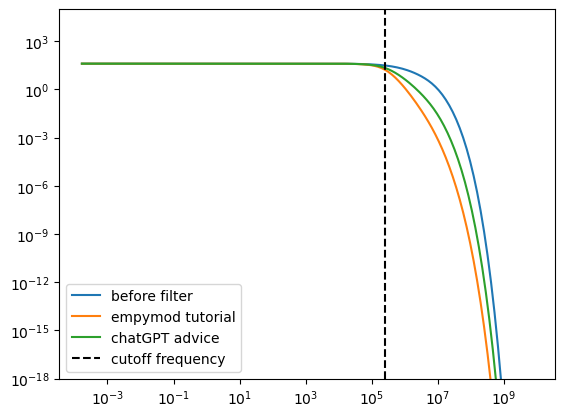

In [38]:
plt.loglog(freq, np.abs(empymod_dpred_ebple_f),label="before filter")

cutofffreq = 2.5e5               # As stated in the WalkTEM manual
h = (1+1j*freq/cutofffreq)**-1   # First order type
h *= (1+1j*freq/3e5)**-1

empymod_dpred_ebple_f_1 = empymod_dpred_ebple_f*h
plt.loglog(freq, np.abs(empymod_dpred_ebple_f_1),label="empymod tutorial")

H_f = 1 / (1 + 1j * (freq / cutofffreq))
empymod_dpred_ebple_f_2 = empymod_dpred_ebple_f * H_f
plt.loglog(freq, np.abs(empymod_dpred_ebple_f_2),label="chatGPT advice")
plt.axvline(cutofffreq, color='k', linestyle='--', label='cutoff frequency')
plt.ylim(bottom=1e-18)
plt.legend()


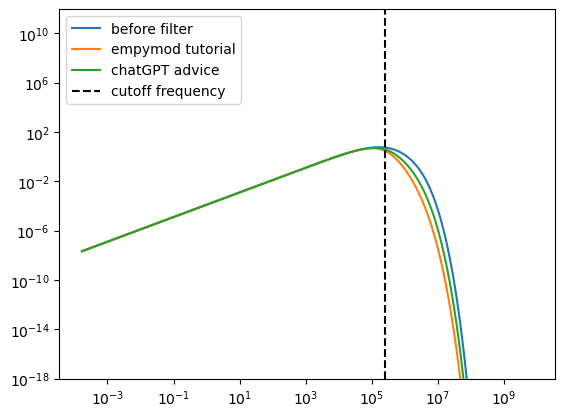

In [39]:
plt.loglog(freq, np.abs(empymod_dpred_bdple_f),label="before filter")

cutofffreq = 2.5e5               # As stated in the WalkTEM manual
h = (1+1j*freq/cutofffreq)**-1   # First order type
h *= (1+1j*freq/3e5)**-1

empymod_dpred_bdple_f_1 = empymod_dpred_bdple_f*h
plt.loglog(freq, np.abs(empymod_dpred_bdple_f_1),label="empymod tutorial")

H_f = 1 / (1 + 1j * (freq / cutofffreq))
empymod_dpred_bdple_f_2 = empymod_dpred_bdple_f * H_f
plt.loglog(freq, np.abs(empymod_dpred_bdple_f_2),label="chatGPT advice")
plt.axvline(cutofffreq, color='k', linestyle='--', label='cutoff frequency')
plt.ylim(bottom=1e-18)
plt.legend()


(569, 1)


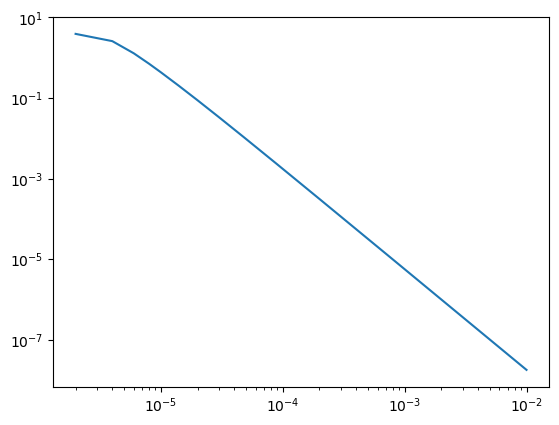

In [40]:
empymod_dpred_bdple_f_t, _ = empymod.model.tem(empymod_dpred_bdple_f_2[:, None],
            np.array([1]), freq, time_clc, -1, ft, ftarg)
print(empymod_dpred_bdple_f_t.shape)
empymod_dpred_bdple_f_t = np.squeeze(empymod_dpred_bdple_f_t)
plt.loglog(time_clc, empymod_dpred_bdple_f_t)
plt.loglog(time_clc, -empymod_dpred_bdple_f_t)


(569, 1)


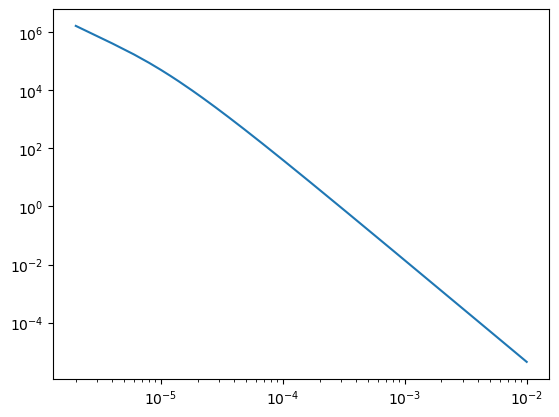

In [41]:
empymod_dpred_ebple_f_t, _ = empymod.model.tem(empymod_dpred_ebple_f[:, None],
            np.array([1]), freq, time_clc, 0, ft, ftarg)
print(empymod_dpred_ebple_f_t.shape)
empymod_dpred_ebple_f_t = np.squeeze(empymod_dpred_ebple_f_t)
plt.loglog(time_clc, empymod_dpred_ebple_f_t)
plt.loglog(time_clc, -empymod_dpred_ebple_f_t)


In [46]:
# empymod_plot = empymodDeepSea(IP_model="pelton", model_base=empymod_model_ebple,
#      res_sea=1/sigma_sea, nlayers=nlayers,btm_fix=None)
empymod_plot=empymod_IPinv(
    model_base=empymod_model_bdple, nlayer=nlayer)


In [59]:
def plot_model(depth,res, depth_min=-100, depth_max=100,ax=None, **kwargs):
    """
    Plot a single model (e.g., resistivity, chargeability) with depth.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    # Default plotting parameters
    default_kwargs = {
        "linestyle": "-",
        "color": "orange",
        "linewidth": 1.0,
        "marker": None,
        "label": "model",
    }
    default_kwargs.update(kwargs)
    model =res

    # Prepare depth and model data for plotting
    depth = np.r_[depth_min + depth[0], 
                    depth,
                    depth_max + depth[-1] ]
    depth_plot = np.vstack([depth, depth]).flatten(order="F")[1:-1]
#       depth_plot = np.hstack([depth_plot, depth_plot[-1] * 1.5])  # Extend depth for plot
    model_plot = np.vstack([model, model]).flatten(order="F")

    # Plot model with depth
    ax.plot(model_plot, depth_plot, **default_kwargs)
    return ax

(50.0, -50.0)

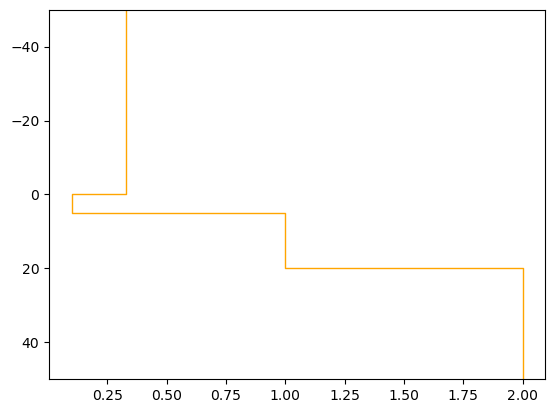

In [60]:
depth = np.r_[0,5,20]
res = np.r_[0.33,0.1,1,2]
plot_model(depth,res, depth_min=-100, depth_max=100,ax=None)
plt.ylim([50,-50])
   

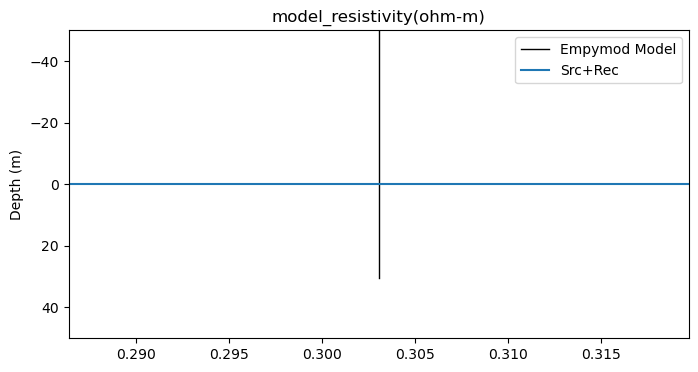

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# Plot the model without overwriting the ax object
empymod_plot.plot_model(model=res, ax=ax, color='k', label='Empymod Model')
ax.axhline(tx_depth, label="Src+Rec")
# Now you can modify the axis properties
ax.set_ylim([50, -50])
ax.set_ylabel('Depth (m)')
ax.set_title("model_resistivity(ohm-m)")
ax.legend()
plt.show()


In [48]:
empymod_ebple_four = empymod.bipole(res=res, **empymod_model_ebple)
## Sum the four sides of the transmitter loop
empymod_ebple = np.sum(empymod_ebple_four, axis=1)
# Multiply by the number of turns
empymod_dpred_ebple =  empymod_ebple 
print(f'empymod_bple: {empymod_dpred_ebple.shape}')



:: empymod START  ::  v2.3.2

   time        [s] :  2E-06 - 0.01 : 569  [min-max; #]
                   :  2E-06 4E-06 6E-06 8E-06 1E-05 1.2E-05 1.4E-05 1.6E-05 1.8E-05 2E-05 2.2E-05 2.4E-05 2.6E-05 2.8E-05 3E-05 3.2E-05 3.4E-05 3.6E-05 3.8E-05 4E-05 4.2E-05 4.4E-05 4.6E-05 4.8E-05 5E-05 5.2E-05 5.4E-05 5.6E-05 5.8E-05 6E-05 6.2E-05 6.4E-05 6.6E-05 6.8E-05 7E-05 7.2E-05 7.4E-05 7.6E-05 7.8E-05 8E-05 8.2E-05 8.4E-05 8.6E-05 8.8E-05 9E-05 9.2E-05 9.4E-05 9.6E-05 9.8E-05 0.0001 0.000102 0.000104 0.000106 0.000108 0.00011 0.000112 0.000114 0.000116 0.000118 0.00012 0.000122 0.000124 0.000126 0.000128 0.00013 0.000132 0.000134 0.000136 0.000138 0.00014 0.000142 0.000144 0.000146 0.000148 0.00015 0.000152 0.000154 0.000156 0.000158 0.00016 0.000162 0.000164 0.000166 0.000168 0.00017 0.000172 0.000174 0.000176 0.000178 0.00018 0.000182 0.000184 0.000186 0.000188 0.00019 0.000192 0.000194 0.000196 0.000198 0.0002 0.000202 0.000204 0.000206 0.000208 0.00021 0.000212 0.000214 0.000216 0.000218 

In [49]:
empymod_bdple_four = empymod.bipole(res=res, **empymod_model_bdple)
empymod_bdple = np.sum(empymod_bdple_four, axis=1)
empymod_dpred_bdple =  empymod_bdple 
print(empymod_dpred_bdple.shape)



:: empymod START  ::  v2.3.2

   time        [s] :  2E-06 - 0.01 : 569  [min-max; #]
                   :  2E-06 4E-06 6E-06 8E-06 1E-05 1.2E-05 1.4E-05 1.6E-05 1.8E-05 2E-05 2.2E-05 2.4E-05 2.6E-05 2.8E-05 3E-05 3.2E-05 3.4E-05 3.6E-05 3.8E-05 4E-05 4.2E-05 4.4E-05 4.6E-05 4.8E-05 5E-05 5.2E-05 5.4E-05 5.6E-05 5.8E-05 6E-05 6.2E-05 6.4E-05 6.6E-05 6.8E-05 7E-05 7.2E-05 7.4E-05 7.6E-05 7.8E-05 8E-05 8.2E-05 8.4E-05 8.6E-05 8.8E-05 9E-05 9.2E-05 9.4E-05 9.6E-05 9.8E-05 0.0001 0.000102 0.000104 0.000106 0.000108 0.00011 0.000112 0.000114 0.000116 0.000118 0.00012 0.000122 0.000124 0.000126 0.000128 0.00013 0.000132 0.000134 0.000136 0.000138 0.00014 0.000142 0.000144 0.000146 0.000148 0.00015 0.000152 0.000154 0.000156 0.000158 0.00016 0.000162 0.000164 0.000166 0.000168 0.00017 0.000172 0.000174 0.000176 0.000178 0.00018 0.000182 0.000184 0.000186 0.000188 0.00019 0.000192 0.000194 0.000196 0.000198 0.0002 0.000202 0.000204 0.000206 0.000208 0.00021 0.000212 0.000214 0.000216 0.000218 

## Plot observation

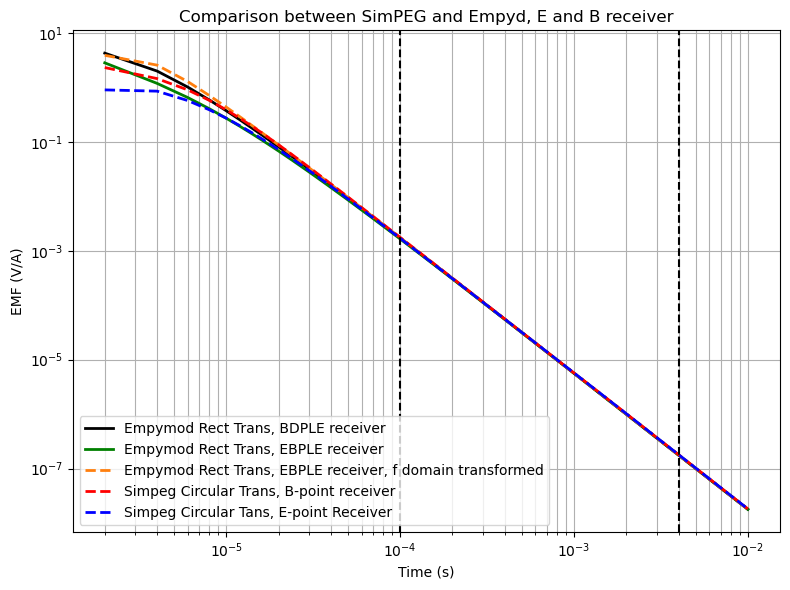

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.loglog(time_clc, empymod_dpred_bdple, 'k-' , linewidth = 2,
          label='Empymod Rect Trans, BDPLE receiver') 
ax.loglog(time_clc, empymod_dpred_ebple, 'g-' , linewidth = 2,
           label='Empymod Rect Trans, EBPLE receiver') 
ax.loglog(time_clc, empymod_dpred_bdple_f_t, color='C1',linestyle='--' , linewidth = 2,
           label='Empymod Rect Trans, EBPLE receiver, f domain transformed') 

ax.loglog(time_simpeg , dpred_simpeg_bdple,  "r--", linewidth = 2,
          label="Simpeg Circular Trans, B-point receiver")
ax.loglog(time_simpeg , dpred_simpeg_ebple,  "b--", linewidth = 2,
           label="Simpeg Circular Tans, E-point Receiver")
ax.legend()
ax.axvline(1e-4, color='k', linestyle='--', label='Recording time')
ax.axvline(4e-3, color='k', linestyle='--')  # No need to repeat the label

ax.grid(True, which="both")
ax.set_xlabel("Time (s)")
ax.set_ylabel("EMF (V/A)")
ax.set_title("Comparison between SimPEG and Empyd, E and B receiver")
plt.tight_layout()
